In [78]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LogNorm

In [2]:
#Read in data
data = Table.read("data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits")
display(data.to_pandas().head())

,x,y,z,A_O
0,10.020546,-15.421509,-3.241711,8.428943
1,-13.487837,5.663507,-0.802306,8.671107
2,6.642289,-0.138942,-0.585961,8.891596
3,0.203939,4.112373,-0.147622,8.977195
4,-20.824045,6.971037,-1.758061,8.326950


In [21]:
# Create radius column
# data["r"] = np.sqrt(data["x"]**2 + data["y"]**2 + data["z"]**2)
data["r"] = np.sqrt(data["x"]**2 + data["y"]**2)

In [57]:
#Perform linear fit
fit = linregress(data["r"], data["A_O"])
AO_fit = fit.slope*data["r"] + fit.intercept
residual = data["A_O"] - AO_fit
print(fit)
print("R^2 =", fit.rvalue**2)

LinregressResult(slope=-0.03419647244360147, intercept=9.127839345362716, rvalue=-0.9552693175922453, pvalue=0.0, stderr=1.4802363801498309e-05, intercept_stderr=0.00023227643278613057)
R^2 = 0.9125394691331541


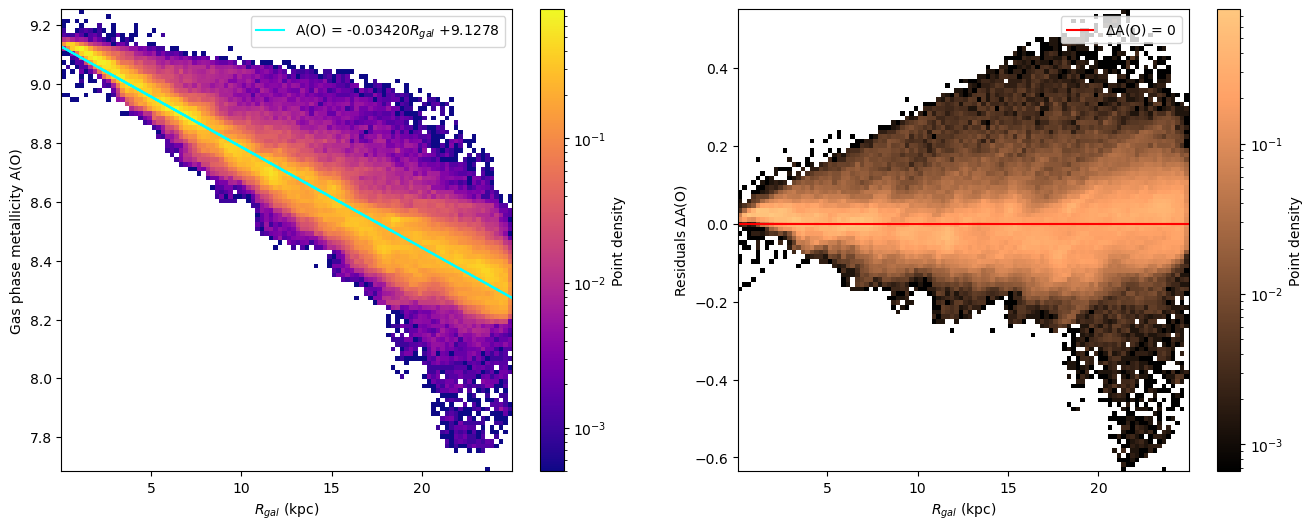

In [66]:
# Set up figure
fig,axs = plt.subplots(1, 2, figsize=(16,6))
ax1 = axs[0]
ax2 = axs[1]

# 2d Histogram of A(O) vs R
hist, x, y, mesh = ax1.hist2d(data["r"], data["A_O"], bins=100, density=True, cmap="plasma", norm=LogNorm())

ax1.plot(data["r"], AO_fit, color="cyan")
plt.colorbar(mesh, ax=ax1, label="Point density")
ax1.set_xlabel("$R_{gal}$ (kpc)")
ax1.set_ylabel("Gas phase metallicity A(O)")
ax1.legend([f"A(O) = {fit.slope:.5f}" + "$R_{gal}$" + f" +{fit.intercept:.4f}"])

# 2d Histogram of residuals
hist, x, y, mesh2 = ax2.hist2d(data["r"], residual, bins=100, density=True, cmap="copper", norm=LogNorm())
ax2.hlines(0, 0, max(data["r"]), color="red", label="$\Delta$A(O) = 0")

plt.colorbar(mesh2, ax=ax2, label="Point density")
ax2.set_xlabel("$R_{gal}$ (kpc)")
ax2.set_ylabel("Residuals $\Delta$A(O)")
ax2.legend()

plt.savefig("figures/q3_AOfit.png", dpi=200, bbox_inches="tight")

plt.show()

The simple linear fit gives us fitting parameters of 
$$A(O) = (-0.03420 \pm 0.00002)R_{gal} + (9.1278 \pm 0.0002)$$
with no hyperparameters. The correlation coefficient is $R^2 = 0.9125$ and the p-value is reported as 0.0 (i.e. too small for double precision numbers). The small p-value implies that there is a high likelihood for a fundamental relationship existing, and the $R^2$ value shows a convincing but not perfect fit. Visually, the residual plot shows that the scatter increases over radius. The RMS can be used to quantify this increasing scatter over radius, using the below plot.

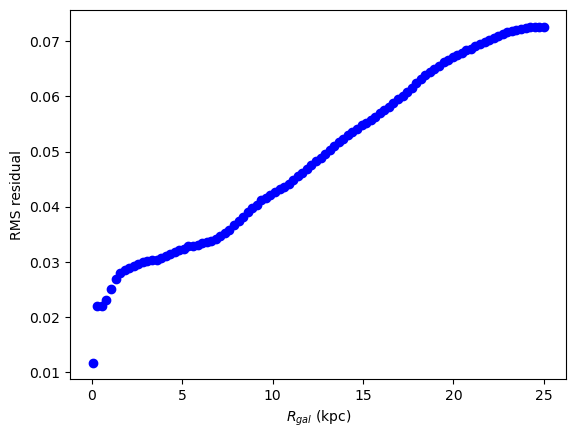

In [63]:
for i in np.linspace(0.01+min(data["r"]), max(data["r"]), 100):
    plt.scatter(i, np.sqrt(np.mean(residual[data["r"]<i]**2)), color="blue")

plt.xlabel("$R_{gal}$ (kpc)")
plt.ylabel("RMS residual")

plt.show()

The RMS starts at ~0.03 for low radii and increases to ~0.07 near the end. This means A(O) can be safely determined down to one decimal point from the fit.

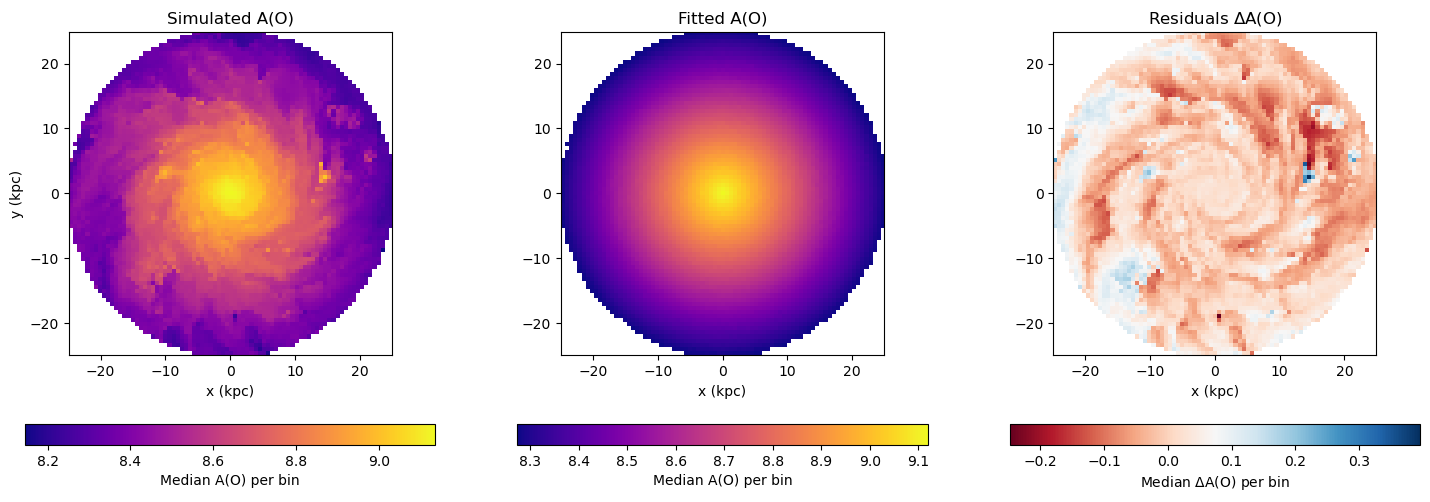

In [149]:
num_bins = 79

fig,axs = plt.subplots(1, 3, figsize = (18,6))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

# Compute the median A(O) per 2d bin
sim_grid, x_edge, y_edge, nbin = binned_statistic_2d(
    data["x"], data["y"], data["A_O"], statistic='median', bins=num_bins
)

img1 = ax1.imshow(sim_grid.T, #Transpose here, since imshow swaps axes
           extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           cmap = "plasma")

fig.colorbar(img1, ax=ax1, location="bottom", label="Median A(O) per bin")
ax1.set_title("Simulated A(O)")
ax1.set_xlabel("x (kpc)")
ax1.set_ylabel("y (kpc)")


##### Fitted A(O) ####
fit_grid, x_edge, y_edge, nbin = binned_statistic_2d(
    data["x"], data["y"], AO_fit, statistic='median', bins=num_bins
)

img2 = ax2.imshow(fit_grid.T, #Transpose here, since imshow swaps axes
           extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           cmap = "plasma")

fig.colorbar(img2, ax=ax2, location="bottom", label="Median A(O) per bin")


ax2.set_title("Fitted A(O)")
ax2.set_xlabel("x (kpc)")

##### Residuals #####
res_grid, x_edge, y_edge, nbin = binned_statistic_2d(
    data["x"], data["y"], residual, statistic='median', bins=num_bins
)

img3 = ax3.imshow(res_grid.T, #Transpose here, since imshow swaps axes
           extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           cmap = "RdBu")

fig.colorbar(img3, ax=ax3, location="bottom", label="Median $\Delta$A(O) per bin")


ax3.set_title("Residuals $\Delta$A(O)")
ax3.set_xlabel("x (kpc)")

plt.savefig("figures/AO_xy.png", dpi=200, bbox_inches="tight")
plt.show()


For the above plot, I use 79 bins as it was the highest number of bins that has no empty cells in the middle. Having a higher number of bins than this would create empty cells---implying that there are no particles within those bins---while having a lower number would smooth out important structure in the simulation plot.

From the above plot, the major difference between the simulation and the fit is in the filamentary structure of the galaxy, which contradictions the assumption that A(O) varies only with radius. This assumption is fine for the inner regions where the galaxy's central bulge dominates and the spiral arms are close to one another. Far off, this assumption breaks down because there is significant variation in A(O) as you traverse the angle around a fixed radius, since the spiral arms are further apart here.

Besides the spiral arms, there is also a special point around the co-ordinate (15,2) with a very high A(O). This creates a large positive residual in the residual plot. There may be some interesting physics happening here (e.g. a recent supernova or recent star formation that changes the metallicity) that is not fully captured by a simple radial model.